In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Dense, Input, Softmax, BatchNormalization, Conv2D, MaxPool2D, 
                                     AveragePooling2D, Add, Flatten, Dropout, Activation, ZeroPadding2D)
from tensorflow.keras.optimizers import Adam

In [2]:
# Load data:

data = tf.keras.datasets.cifar10.load_data()
(x_train, y_train), (x_test, y_test) = data

170500096/170498071 [==============================] - 60s 0us/step


In [3]:
print('x_train shape:', x_train.shape)
print('x_teset shape:', x_test.shape)

m_train_examples = x_train.shape[0]
m_test_examples = x_test.shape[0]

print('# of train examples:', m_train_examples)
print('# of test examples:', m_test_examples)

image_shape = x_train.shape[1:]
print('image shape:', image_shape)

x_train shape: (50000, 32, 32, 3)
x_teset shape: (10000, 32, 32, 3)
# of train examples: 50000
# of test examples: 10000
image shape: (32, 32, 3)


In [4]:
LABEL_NAMES = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

NUM_CLASSES = len(LABEL_NAMES)

In [5]:
# Process Data:
# TODO: we subtract TRAIN mean and divide by TRAIN std on the TEST distribution as well -- why?
mean = np.mean(x_train)
std = np.std(x_train)

x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

In [6]:
# convert to one-hot encoding:
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


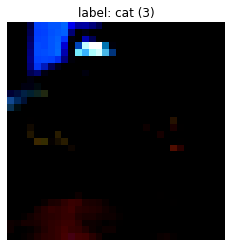

In [7]:
# Explore data:

RAND_INDEX = np.random.randint(m_train_examples)
label = np.argmax(y_train[RAND_INDEX]) # we use `argmax` since we converted the labels from list of ints to one-hot encoding

img = x_train[RAND_INDEX]
img_title = 'label: %s (%s)' % (LABEL_NAMES[label], label)

plt.imshow(img)
plt.title(img_title)
plt.axis('off')
plt.show()

In [10]:
# Setup data generator:

BATCH_SIZE = 128

datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

datagen.fit(x_train)

train_generator = datagen.flow(
    x_train,
    y_train,
    batch_size=BATCH_SIZE
)

In [20]:
def identity_block(input_tensor, kernel_size, num_filters, stage_label, block_label):
    """ Standard block in ResNet -- corresponds to when input activation (e.g. a[l]) has same dimension as output activation
        a[l+2].
        
        Note: Identity blocks' shortcuts (skip connections) are parameter-free (since they're simply adding input tensors)
    """
    
    num_filters_1, num_filters_2, num_filters_3 = num_filters
    CONV_BASE_NAME = 'conv_%s_%s' % (stage_label, block_label)
    BATCH_NORM_BASE_NAME = 'batch_norm_%s_%s' % (stage_label, block_label)
    
    x = Conv2D(num_filters_1, (1, 1), padding='valid', name=CONV_BASE_NAME+'a')(input_tensor) # strides = (1, 1) which is the default arg
    x = BatchNormalization(axis=-1, name=BATCH_NORM_BASE_NAME+'a')(x) # axis should be set to features
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters_2, kernel_size, padding='same', name=CONV_BASE_NAME+'b')(x)
    x = BatchNormalization(axis=-1, name=BATCH_NORM_BASE_NAME+'b')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters_3, (1, 1), padding='valid', name=CONV_BASE_NAME+'c')(x)
    x = BatchNormalization(axis=-1, name=BATCH_NORM_BASE_NAME+'c')(x)
    x = tf.keras.layers.add([x, input_tensor]) # inject skip connection
    x = Activation('relu')(x)
    
    return x

def conv_block(input_tensor, kernel_size, num_filters, stage_label, block_label, strides=(2, 2)):
    """ The conv block is used when input and output have different dimensions.
    
        The conv black is differs from identity block by having convolution layer in the skip conneciton; 
        The conv layer in the shortcut is used to resize the input to different dimension so that the dimensions 
        match when the shortcut is added (tf.keras.layers.add) back to the main path.
    """
    
    num_filters_1, num_filters_2, num_filters_3 = num_filters
    CONV_BASE_NAME = 'conv_%s_%s' % (stage_label, block_label)
    BATCH_NORM_BASE_NAME = 'batch_norm_%s_%s' % (stage_label, block_label)
    
    # if strides != 1, then we are downsampling/changing dimensions
    # in standard practice, the image dimensions decrease in later layers, so this is ok
    x = Conv2D(num_filters_1, (1, 1), strides=strides, padding='valid', name=CONV_BASE_NAME+'a')(input_tensor)
    x = BatchNormalization(axis=-1, name=BATCH_NORM_BASE_NAME+'a')(x) # axis should be set to features
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters_2, kernel_size, padding='same', name=CONV_BASE_NAME+'b')(x)
    x = BatchNormalization(axis=-1, name=BATCH_NORM_BASE_NAME+'b')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters_3, (1, 1), padding='valid', name=CONV_BASE_NAME+'c')(x)
    x = BatchNormalization(axis=-1, name=BATCH_NORM_BASE_NAME+'c')(x)
    x = Activation('relu')(x)
    
    shortcut = Conv2D(num_filters_3, (1, 1), strides=strides, padding='valid', name=CONV_BASE_NAME+'shortcut')(input_tensor)
    shortcut = BatchNormalization(axis=-1, name=BATCH_NORM_BASE_NAME+'shortcut')(shortcut)
    
    x = tf.keras.layers.add([x, shortcut])
    x = Activation('relu')(x)
    
    return x

In [26]:
# Model:

num_classes=6

i = Input(shape=image_shape)
x = ZeroPadding2D((3, 3))(i)
x = Conv2D(64, (7, 7), strides=(2, 2), name='conv_1')(x)
x = BatchNormalization(name='bn_conv_1')(x) # axis=-1 is already default
x = Activation('relu')(x)
x = MaxPool2D((3, 3), strides=(2, 2), name='max_pool_1')(x)

x = conv_block(x, 3, [64, 64, 256], stage_label=2, block_label='a', strides=(1, 1))
x = identity_block(x, 3, [64, 64, 256], stage_label=2, block_label='b')
x = identity_block(x, 3, [64, 64, 256], stage_label=2, block_label='c')

x = conv_block(x, 3, [128, 128, 512], stage_label=3, block_label='a', strides=(2, 2))
x = identity_block(x, 3, [128, 128, 512], stage_label=3, block_label='b')
x = identity_block(x, 3, [128, 128, 512], stage_label=3, block_label='c')
x = identity_block(x, 3, [128, 128, 512], stage_label=3, block_label='d')

x = conv_block(x, 3, [256, 256, 1024], stage_label=4, block_label='a', strides=(2, 2))
x = identity_block(x, 3, [256, 256, 1024], stage_label=4, block_label='b')
x = identity_block(x, 3, [256, 256, 1024], stage_label=4, block_label='c')
x = identity_block(x, 3, [256, 256, 1024], stage_label=4, block_label='d')
x = identity_block(x, 3, [256, 256, 1024], stage_label=4, block_label='e')
x = identity_block(x, 3, [256, 256, 1024], stage_label=4, block_label='f')

x = conv_block(x, 3, [512, 512, 2048], stage_label=5, block_label='a', strides=(2, 2))
x = identity_block(x, 3, [512, 512, 2048], stage_label=5, block_label='b')
x = identity_block(x, 3, [512, 512, 2048], stage_label=5, block_label='c')

#x = AveragePooling2D((2, 2), name='avg_pool')(x)
x = Flatten()(x)
x = Dense(NUM_CLASSES, activation='softmax', name='fully_connected')(x)

model = Model(i, x)

In [27]:
model.compile(
    optimizer=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_history = model.fit(
    train_generator,
    steps_per_epoch = m_train_examples // BATCH_SIZE,
    epochs=100,
    validation_data=(x_test, y_test)
)

Epoch 1/100
390/390 [==============================] - 42s 87ms/step - loss: 2.2548 - accuracy: 0.3107 - val_loss: 2.0841 - val_accuracy: 0.4438
Epoch 2/100
390/390 [==============================] - 33s 84ms/step - loss: 1.6850 - accuracy: 0.4266 - val_loss: 6.9353 - val_accuracy: 0.3693
Epoch 3/100
390/390 [==============================] - 33s 84ms/step - loss: 1.7342 - accuracy: 0.4319 - val_loss: 3.6359 - val_accuracy: 0.4764
Epoch 4/100
390/390 [==============================] - 33s 85ms/step - loss: 1.6576 - accuracy: 0.4546 - val_loss: 4.5769 - val_accuracy: 0.2688
Epoch 5/100
390/390 [==============================] - 33s 85ms/step - loss: 1.7648 - accuracy: 0.4061 - val_loss: 101.4450 - val_accuracy: 0.1364
Epoch 6/100
390/390 [==============================] - 33s 84ms/step - loss: 1.6942 - accuracy: 0.4311 - val_loss: 1.7392 - val_accuracy: 0.4487
Epoch 7/100
390/390 [==============================] - 33s 83ms/step - loss: 1.4619 - accuracy: 0.4962 - val_loss: 1.3181 - val_

## Model Summary:

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_9 (ZeroPadding2D (None, 38, 38, 3)    0           input_10[0][0]                   
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 16, 16, 64)   9472        zero_padding2d_9[0][0]           
__________________________________________________________________________________________________
bn_conv_1 (BatchNormalization)  (None, 16, 16, 64)   256         conv_1[0][0]                     
______________________________________________________________________________________________

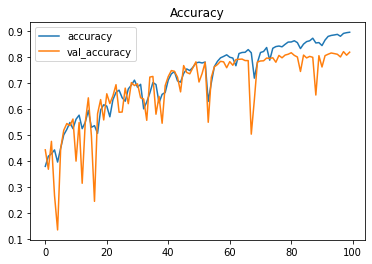

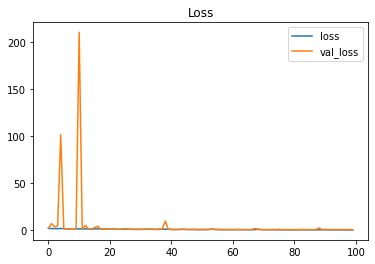

In [29]:
plt.plot(model_history.history['accuracy'], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

plt.plot(model_history.history['loss'], label='loss')
plt.plot(model_history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')
plt.show()